In [4]:
library(quantmod)

get_returns <- function(ticker) {
  prices_data <- getSymbols(ticker, src = "yahoo", auto.assign = FALSE)

  adj_close <- as.data.frame(Ad(prices_data))
  adj_close$Date <- as.Date(rownames(adj_close))
  colnames(adj_close) <- c("Adj.Close", "Date")

  adj_close$Adj.Close <- as.numeric(adj_close$Adj.Close)

  adj_close$log_returns <- c(NA, diff(log(adj_close$Adj.Close)))
  
  adj_close <- adj_close[adj_close$Date <= as.Date('2024-01-01'),]
  
  # Print summary information
  print("Length:")
  print(nrow(adj_close))
  
  print(tail(adj_close))
  
  return(adj_close)
}

df <- get_returns("^N225")
df <- df[, c("Date", "log_returns")]
head(df)

Warning message:
"package 'quantmod' was built under R version 4.3.3"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 4.3.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.3.3"



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"^N225 contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


[1] "Length:"
[1] 4179
           Adj.Close       Date   log_returns
2023-12-22  33169.05 2023-12-22  0.0008620793
2023-12-25  33254.03 2023-12-25  0.0025587646
2023-12-26  33305.85 2023-12-26  0.0015571038
2023-12-27  33681.24 2023-12-27  0.0112078506
2023-12-28  33539.62 2023-12-28 -0.0042134956
2023-12-29  33464.17 2023-12-29 -0.0022520889


,Date,log_returns
,<date>,<dbl>
2007-01-04,2007-01-04,NA
2007-01-05,2007-01-05,-0.015217486
2007-01-09,2007-01-09,0.008516359
2007-01-10,2007-01-10,-0.017283501
2007-01-11,2007-01-11,-0.006171050
2007-01-12,2007-01-12,0.012912921


In [5]:
df2 <- get_returns("^GDAXI")
df2 <- df2[, c("Date", "log_returns")]
head(df2)

Warning message:
"^GDAXI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


[1] "Length:"
[1] 4317
           Adj.Close       Date   log_returns
2023-12-20  16733.05 2023-12-20 -0.0006786283
2023-12-21  16687.42 2023-12-21 -0.0027307148
2023-12-22  16706.18 2023-12-22  0.0011235547
2023-12-27  16742.07 2023-12-27  0.0021460399
2023-12-28  16701.55 2023-12-28 -0.0024231557
2023-12-29  16751.64 2023-12-29  0.0029946250


,Date,log_returns
,<date>,<dbl>
2007-01-02,2007-01-02,NA
2007-01-03,2007-01-03,0.001524020
2007-01-04,2007-01-04,-0.002531840
2007-01-05,2007-01-05,-0.012257191
2007-01-08,2007-01-08,0.002196857
2007-01-09,2007-01-09,0.001025608


In [6]:
merged_df <- merge(df, df2, by = "Date", all = FALSE, suffixes = c("_n225", "_gdaxi"))
head(merged_df)

,Date,log_returns_n225,log_returns_gdaxi
,<date>,<dbl>,<dbl>
1,2007-01-04,NA,-0.002531840
2,2007-01-05,-0.015217486,-0.012257191
3,2007-01-09,0.008516359,0.001025608
4,2007-01-10,-0.017283501,-0.007254460
5,2007-01-11,-0.006171050,0.018220064
6,2007-01-12,0.012912921,0.002668683


In [7]:
merged_df <- na.omit(merged_df)

In [8]:
head(merged_df)

,Date,log_returns_n225,log_returns_gdaxi
,<date>,<dbl>,<dbl>
2,2007-01-05,-0.015217486,-0.012257191
3,2007-01-09,0.008516359,0.001025608
4,2007-01-10,-0.017283501,-0.007254460
5,2007-01-11,-0.006171050,0.018220064
6,2007-01-12,0.012912921,0.002668683
7,2007-01-15,0.008924708,0.003954830


#### ACF plots display correlation with lagged series
#### PACF plots also display correlation with lags but controls for other lags eg autocorrelation between z_t and z_(t+k) that is not accounted for by lags 1 - k-1

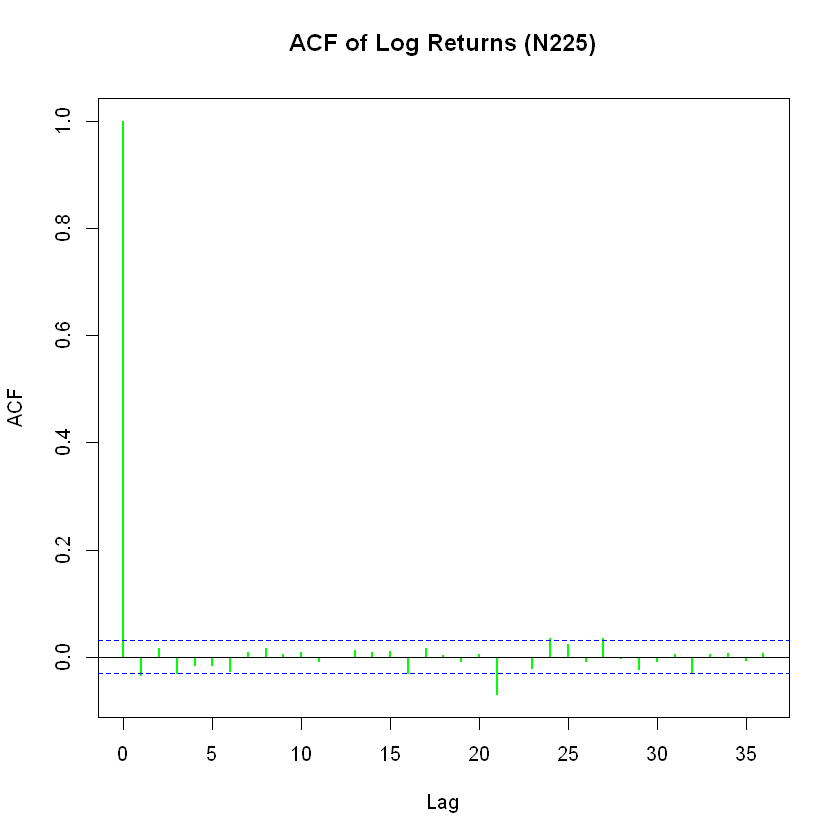

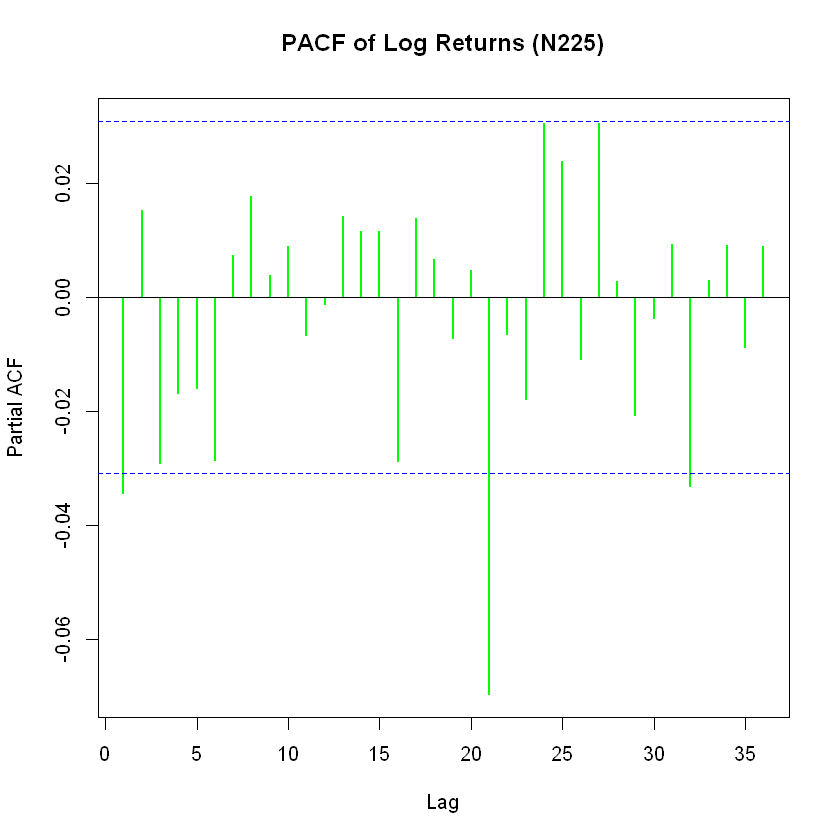

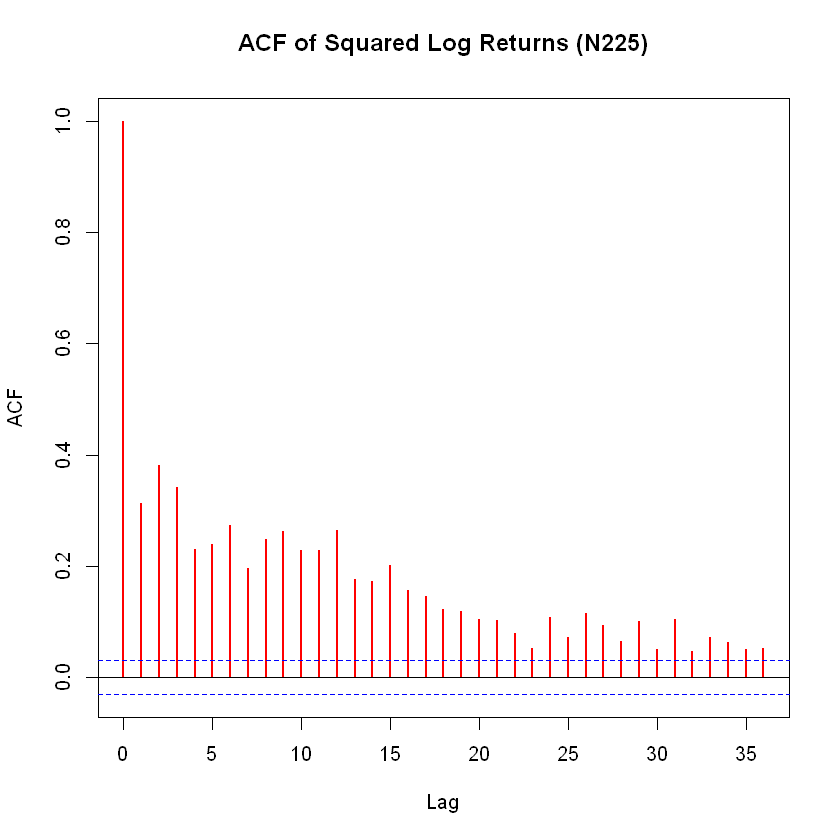

In [9]:
acf(merged_df$log_returns_n225, col="green", lwd=2, main="ACF of Log Returns (N225)") 
pacf(merged_df$log_returns_n225, col="green", lwd=2, main="PACF of Log Returns (N225)")  
acf(merged_df$log_returns_n225^2, col="red", lwd=2, main="ACF of Squared Log Returns (N225)") 

In [10]:
box_test <- function(vals) {
  result1 <- Box.test(vals, lag = 10, type = c("Ljung-Box"))
  result2 <- Box.test(vals^2, lag = 10, type = c("Ljung-Box"))
  return(list(result1, result2))
}
#Ljung-Box Test tests for autocorrelation at specific lags

box_test(merged_df$log_returns_n225)

[[1]]

	Box-Ljung test

data:  vals
X-squared = 16.443, df = 10, p-value = 0.08764


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 3092.1, df = 10, p-value < 2.2e-16



##### Results suggest use of GARCH but not ARMA

In [11]:
library(VineCopula)
install.packages("fGarch")
library(fGarch)
install.packages("KScorrect")
library(KScorrect)
library(stats)
install.packages("ADGofTest")
library(ADGofTest)

Warning message:
"package 'VineCopula' was built under R version 4.3.3"
Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'fGarch' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'fGarch'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\zakit\AppData\Local\R\win-library\4.3\00LOCK\fGarch\libs\x64\fGarch.dll to C:\Users\zakit\AppData\Local\R\win-library\4.3\fGarch\libs\x64\fGarch.dll: Permission denied"
Warning message:
"restored 'fGarch'"



The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\Rtmp658dh6\downloaded_packages


Warning message:
"package 'fGarch' was built under R version 4.3.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")


Attaching package: 'fGarch'


The following object is masked from 'package:TTR':

    volatility


Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'KScorrect' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\Rtmp658dh6\downloaded_packages


Warning message:
"package 'KScorrect' was built under R version 4.3.3"
Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'ADGofTest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\Rtmp658dh6\downloaded_packages


##### Trialling different GARCH models for the Nikkei 225 Returns - we test all possible combinations for 0 < p,q < 4 and all possible conditional distributions

AIC -  
BIC - 


In [12]:
distributions <- c("norm", "snorm", "std", "sstd", "ged", "sged", "QMLE") # Possible distributions
best_model_n225 <- NULL
min_BIC <- Inf # Initialize to a very high value

#R is such a weird programming language
for (dist in distributions) {
    for (p in 1:3) {
        for (q in 1:3) {
            # Dynamically create the formula
            formula <- as.formula(paste("~garch(", p, ",", q, ")", sep = ""))
            
            # Attempt to fit the model
            model <- tryCatch(
                garchFit(formula = formula, data = merged_df$log_returns_n225, trace = FALSE, cond.dist = dist),
                error = function(e) NULL
            )
            
            if (!is.null(model)) {
                current_BIC <- model@fit$ics["BIC"] # Extract BIC - better than AIC
                print(paste("Distribution:", dist, "p:", p, "q:", q, "AIC:", current_BIC))
                
                # Check if the current model has a lower AIC
                if (current_BIC < min_BIC) {
                    min_BIC <- current_BIC
                    best_model_n225 <- model
                }
            }
        }
    }
}



[1] "Distribution: norm p: 1 q: 1 AIC: -5.88240163854614"
[1] "Distribution: norm p: 1 q: 2 AIC: -5.88037599039787"
[1] "Distribution: norm p: 1 q: 3 AIC: -5.87850838372305"
[1] "Distribution: norm p: 2 q: 1 AIC: -5.88036692779694"
[1] "Distribution: norm p: 2 q: 2 AIC: -5.87837680731975"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 2 q: 3 AIC: -5.87709272049974"
[1] "Distribution: norm p: 3 q: 1 AIC: -5.87819119838617"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 3 q: 2 AIC: -5.87627139216193"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 3 q: 3 AIC: -5.87503682725696"
[1] "Distribution: snorm p: 1 q: 1 AIC: -5.89335440421105"
[1] "Distribution: snorm p: 1 q: 2 AIC: -5.89138981039128"
[1] "Distribution: snorm p: 1 q: 3 AIC: -5.88956817141761"
[1] "Distribution: snorm p: 2 q: 1 AIC: -5.89131656518561"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 2 q: 2 AIC: -5.88933391721392"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 2 q: 3 AIC: -5.88781824219288"
[1] "Distribution: snorm p: 3 q: 1 AIC: -5.88913486725559"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 3 q: 2 AIC: -5.88717661939606"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 3 q: 3 AIC: -5.88576234894018"
[1] "Distribution: std p: 1 q: 1 AIC: -5.9109104640962"
[1] "Distribution: std p: 1 q: 2 AIC: -5.90887711778318"
[1] "Distribution: std p: 1 q: 3 AIC: -5.90685171547563"
[1] "Distribution: std p: 2 q: 1 AIC: -5.90888084334013"
[1] "Distribution: std p: 2 q: 2 AIC: -5.90691625316109"
[1] "Distribution: std p: 2 q: 3 AIC: -5.90545020433058"
[1] "Distribution: std p: 3 q: 1 AIC: -5.90672923526336"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: std p: 3 q: 2 AIC: -5.90481585167162"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: std p: 3 q: 3 AIC: -5.90339431113191"
[1] "Distribution: sstd p: 1 q: 1 AIC: -5.91430892833945"
[1] "Distribution: sstd p: 1 q: 2 AIC: -5.91227562897316"
[1] "Distribution: sstd p: 1 q: 3 AIC: -5.91030685576207"
[1] "Distribution: sstd p: 2 q: 1 AIC: -5.91227042135523"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 2 q: 2 AIC: -5.91021096433023"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 2 q: 3 AIC: -5.90868442279099"
[1] "Distribution: sstd p: 3 q: 1 AIC: -5.9101098376715"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 3 q: 2 AIC: -5.90813313833209"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 3 q: 3 AIC: -5.90662852957981"
[1] "Distribution: ged p: 1 q: 1 AIC: -5.91364351988591"
[1] "Distribution: ged p: 1 q: 2 AIC: -5.91160623772964"
[1] "Distribution: ged p: 1 q: 3 AIC: -5.90960007750481"
[1] "Distribution: ged p: 2 q: 1 AIC: -5.91160624028132"
[1] "Distribution: ged p: 2 q: 2 AIC: -5.90960958008472"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: ged p: 2 q: 3 AIC: -5.90805996378195"
[1] "Distribution: ged p: 3 q: 1 AIC: -5.90946016441266"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: ged p: 3 q: 2 AIC: -5.90751325910819"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: ged p: 3 q: 3 AIC: -5.90600407058223"
[1] "Distribution: sged p: 1 q: 1 AIC: -5.9174869954532"
[1] "Distribution: sged p: 1 q: 2 AIC: -5.91545754735848"
[1] "Distribution: sged p: 1 q: 3 AIC: -5.913494286072"
[1] "Distribution: sged p: 2 q: 1 AIC: -5.9154436208567"
[1] "Distribution: sged p: 2 q: 2 AIC: -5.91338799428827"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sged p: 2 q: 3 AIC: -5.91173889389566"
[1] "Distribution: sged p: 3 q: 1 AIC: -5.9132947495795"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sged p: 3 q: 2 AIC: -5.91131097945056"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sged p: 3 q: 3 AIC: -5.909683000687"
[1] "Distribution: QMLE p: 1 q: 1 AIC: -5.88240163854614"
[1] "Distribution: QMLE p: 1 q: 2 AIC: -5.88037599039787"
[1] "Distribution: QMLE p: 1 q: 3 AIC: -5.87850838372305"
[1] "Distribution: QMLE p: 2 q: 1 AIC: -5.88036692779694"
[1] "Distribution: QMLE p: 2 q: 2 AIC: -5.87837680731975"
[1] "Distribution: QMLE p: 2 q: 3 AIC: -5.87709272049974"
[1] "Distribution: QMLE p: 3 q: 1 AIC: -5.87819119838617"
[1] "Distribution: QMLE p: 3 q: 2 AIC: -5.87627139216193"
[1] "Distribution: QMLE p: 3 q: 3 AIC: -5.87503682725696"


In [13]:
# Print the best model summary
if (!is.null(best_model_n225)) {
    print(best_model_n225)
} else {
    cat("No valid model was found.\n")
}



Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_n225, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000002305b372d38>
 [data = merged_df$log_returns_n225]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1       beta1        skew       shape  
3.4972e-04  5.2657e-06  1.1955e-01  8.5560e-01  9.1005e-01  1.4331e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     3.497e-04   1.758e-04    1.989   0.0467 *  
omega  5.266e-06   1.163e-06    4.527 5.98e-06 ***
alpha1 1.195e-01   1.389e-02    8.610  < 2e-16 ***
beta1  8.556e-01   1.636e-02   52.291  < 2e-16 ***
skew   9.101e-01   1.820e-02   49.997  < 2e-16 ***
shape  1.433e+00   4.658e-02   30.765  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 11975.28    normalized:  2.964911 

Description:
 Sun D

In [14]:
print(best_model_n225@fit$ics[1])
print(best_model_n225@fit$ics[2])
print(best_model_n225@fit$ics[3])

      AIC 
-5.926851 


      BIC 
-5.917487 
      SIC 
-5.926856 


##### Calculate Residuals between modelled returns and original

In [15]:
res_n225 <- residuals(best_model_n225, standardize = TRUE)

In [16]:
print("Autocorrelation/ARCH effect tests for residuals (N225):")  
print(box_test(res_n225))

[1] "Autocorrelation/ARCH effect tests for residuals (N225):"
[[1]]

	Box-Ljung test

data:  vals
X-squared = 5.7773, df = 10, p-value = 0.8336


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 13.737, df = 10, p-value = 0.1853




#### Probability Integral Transform: for rv X with given distribution, then F_x (X) ~ U(0,1)

In [17]:
model_coefs_n225 <- best_model_n225@fit$coef

In [18]:
# u_n225 <- psstd(res_n225, nu = model_coefs["shape"], xi = model_coefs["skew"])
u_n225 <- psged(res_n225, nu = model_coefs_n225["shape"], xi = model_coefs_n225["skew"])

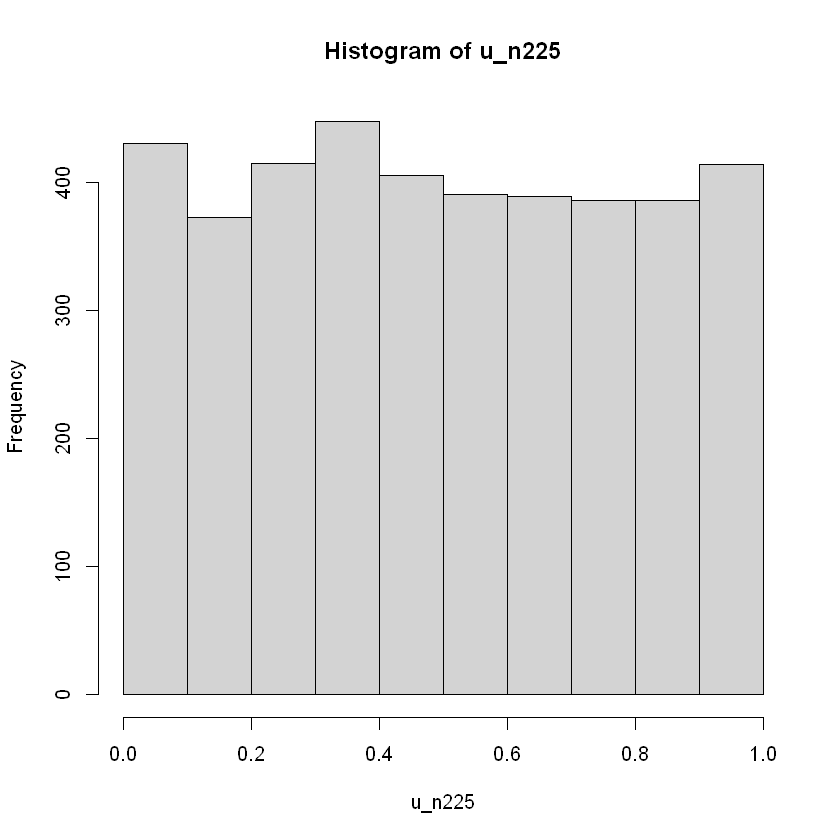

In [19]:
hist(u_n225) #should look uniform

##### Other Uniformity Tests

In [20]:
KStest2 <- LcKS(u_n225, cdf = "punif")
print("Kolmogorov-Smirnov test")
print(KStest2$p.value)

ADtest2 <- ad.test(u_n225, null = "punif")
print("Anderson-Darling test")
print(ADtest2$p.value)

[1] "Kolmogorov-Smirnov test"
[1] 0.0874
[1] "Anderson-Darling test"
       AD 
0.2024887 


##### Doing the same for GDAXI

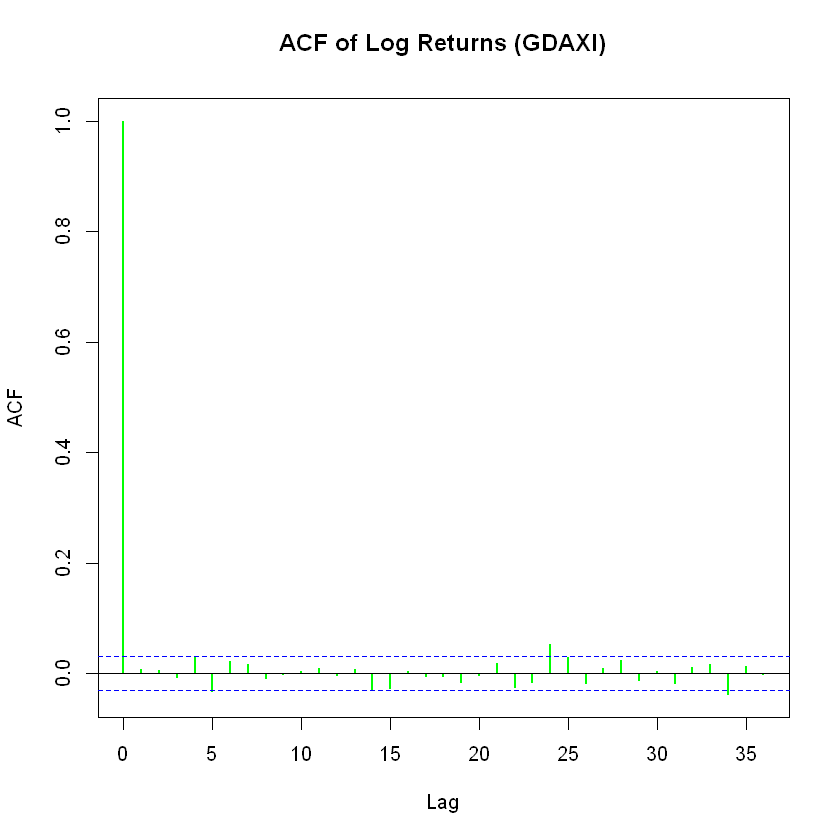

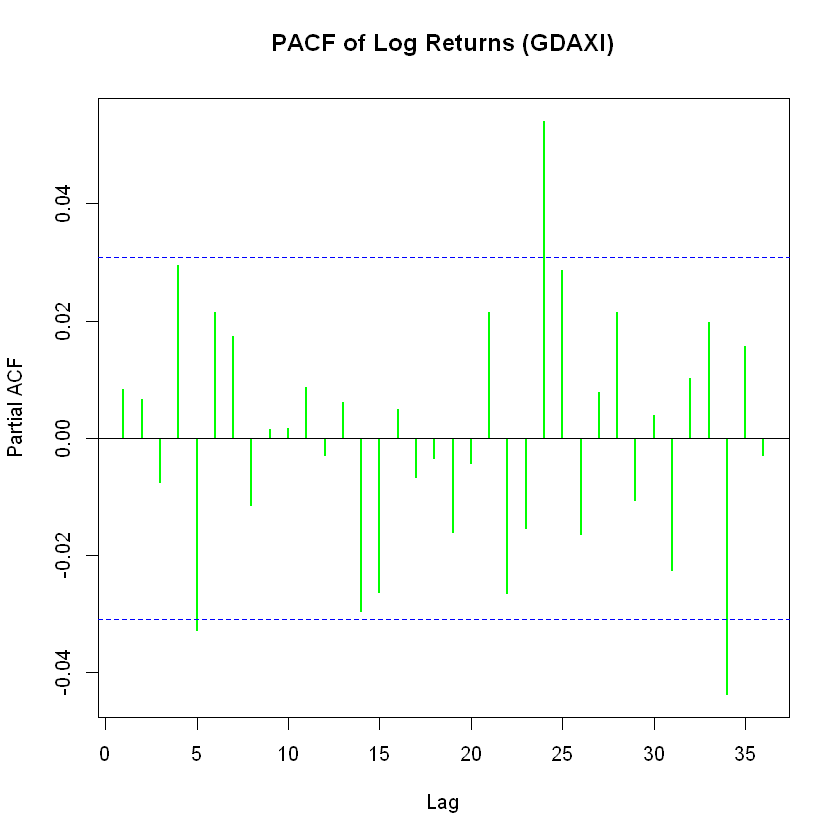

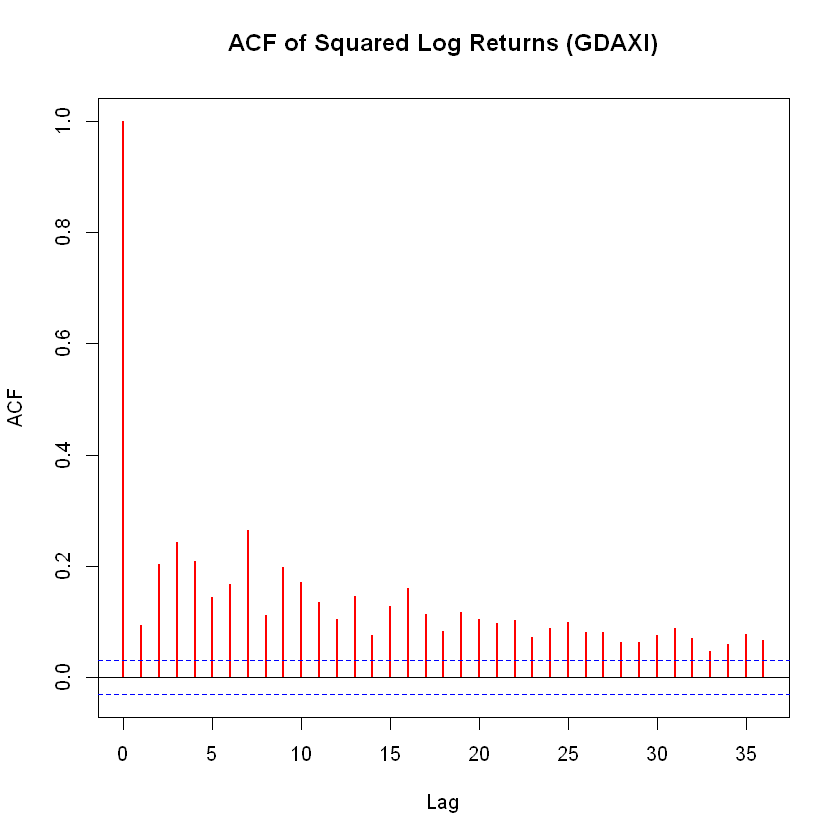

In [21]:
acf(merged_df$log_returns_gdaxi, col="green", lwd=2, main="ACF of Log Returns (GDAXI)") 
pacf(merged_df$log_returns_gdaxi, col="green", lwd=2, main="PACF of Log Returns (GDAXI)")  
acf(merged_df$log_returns_gdaxi^2, col="red", lwd=2, main="ACF of Squared Log Returns (GDAXI)") 

In [22]:
box_test <- function(vals) {
  result1 <- Box.test(vals, lag = 10, type = c("Ljung-Box"))
  result2 <- Box.test(vals^2, lag = 10, type = c("Ljung-Box"))
  return(list(result1, result2))
}
#Ljung-Box Test tests for autocorrelation at specific lags

box_test(merged_df$log_returns_gdaxi)

[[1]]

	Box-Ljung test

data:  vals
X-squared = 11.847, df = 10, p-value = 0.2955


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 1426.9, df = 10, p-value < 2.2e-16



In [23]:
distributions <- c("norm", "snorm", "std", "sstd", "ged", "sged") # Possible distributions
best_model_gdaxi <- NULL
min_BIC_gdaxi <- Inf # Initialize to a very high value

#R is such a weird programming language
for (dist in distributions) {
    for (p in 1:3) {
        for (q in 1:3) {
            # Dynamically create the formula
            formula <- as.formula(paste("~garch(", p, ",", q, ")", sep = ""))
            
            # Attempt to fit the model
            model <- tryCatch(
                garchFit(formula = formula, data = merged_df$log_returns_gdaxi, trace = FALSE, cond.dist = dist),
                error = function(e) NULL
            )
            
            if (!is.null(model)) {
                current_BIC <- model@fit$ics["BIC"] # Extract BIC - better for true model fit than AIC
                print(paste("Distribution:", dist, "p:", p, "q:", q, "BIC:", current_BIC))
                
                # Check if the current model has a lower BIC
                if (current_BIC < min_BIC) {
                    min_BIC_gdaxi <- current_BIC
                    best_model_gdaxi <- model
                }
            }
        }
    }
}




[1] "Distribution: norm p: 1 q: 1 BIC: -6.05496871941095"
[1] "Distribution: norm p: 1 q: 2 BIC: -6.05289534388828"
[1] "Distribution: norm p: 1 q: 3 BIC: -6.05068463746238"
[1] "Distribution: norm p: 2 q: 1 BIC: -6.05386767580526"
[1] "Distribution: norm p: 2 q: 2 BIC: -6.05182937546452"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 2 q: 3 BIC: -6.04973684636475"
[1] "Distribution: norm p: 3 q: 1 BIC: -6.05171326675246"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 3 q: 2 BIC: -6.04970616205508"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: norm p: 3 q: 3 BIC: -6.04777391141023"
[1] "Distribution: snorm p: 1 q: 1 BIC: -6.0640481308857"
[1] "Distribution: snorm p: 1 q: 2 BIC: -6.06197064812504"
[1] "Distribution: snorm p: 1 q: 3 BIC: -6.05976302614112"
[1] "Distribution: snorm p: 2 q: 1 BIC: -6.06300867626049"
[1] "Distribution: snorm p: 2 q: 2 BIC: -6.06098444443798"
[1] "Distribution: snorm p: 2 q: 3 BIC: -6.05892011308304"
[1] "Distribution: snorm p: 3 q: 1 BIC: -6.06085746371191"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 3 q: 2 BIC: -6.05884312063536"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: snorm p: 3 q: 3 BIC: -6.05693666268143"
[1] "Distribution: std p: 1 q: 1 BIC: -6.10905109671634"
[1] "Distribution: std p: 1 q: 2 BIC: -6.10699216655874"
[1] "Distribution: std p: 1 q: 3 BIC: -6.10482014513289"
[1] "Distribution: std p: 2 q: 1 BIC: -6.10806163181152"
[1] "Distribution: std p: 2 q: 2 BIC: -6.10610806377123"
[1] "Distribution: std p: 2 q: 3 BIC: -6.10419057190236"
[1] "Distribution: std p: 3 q: 1 BIC: -6.10594798504588"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: std p: 3 q: 2 BIC: -6.10390722878345"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: std p: 3 q: 3 BIC: -6.10216392533927"
[1] "Distribution: sstd p: 1 q: 1 BIC: -6.11226430816005"
[1] "Distribution: sstd p: 1 q: 2 BIC: -6.11019906693433"
[1] "Distribution: sstd p: 1 q: 3 BIC: -6.10803304159993"
[1] "Distribution: sstd p: 2 q: 1 BIC: -6.11136862950132"
[1] "Distribution: sstd p: 2 q: 2 BIC: -6.10942633382949"
[1] "Distribution: sstd p: 2 q: 3 BIC: -6.10756879649967"
[1] "Distribution: sstd p: 3 q: 1 BIC: -6.10925831550904"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 3 q: 2 BIC: -6.10732147529409"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sstd p: 3 q: 3 BIC: -6.10555332146286"
[1] "Distribution: ged p: 1 q: 1 BIC: -6.11261184298648"
[1] "Distribution: ged p: 1 q: 2 BIC: -6.11054868373496"
[1] "Distribution: ged p: 1 q: 3 BIC: -6.10838888343669"
[1] "Distribution: ged p: 2 q: 1 BIC: -6.11136603971859"
[1] "Distribution: ged p: 2 q: 2 BIC: -6.10936435100225"
[1] "Distribution: ged p: 2 q: 3 BIC: -6.10734987109424"
[1] "Distribution: ged p: 3 q: 1 BIC: -6.10925095155925"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: ged p: 3 q: 2 BIC: -6.10725565205018"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: ged p: 3 q: 3 BIC: -6.10531661835861"
[1] "Distribution: sged p: 1 q: 1 BIC: -6.11745524702648"
[1] "Distribution: sged p: 1 q: 2 BIC: -6.1153858647277"
[1] "Distribution: sged p: 1 q: 3 BIC: -6.11267852063105"
[1] "Distribution: sged p: 2 q: 1 BIC: -6.11627660970625"
[1] "Distribution: sged p: 2 q: 2 BIC: -6.11409485963727"
[1] "Distribution: sged p: 2 q: 3 BIC: -6.11234162877871"
[1] "Distribution: sged p: 3 q: 1 BIC: -6.11416433844097"
[1] "Distribution: sged p: 3 q: 2 BIC: -6.11213013635259"


Warning message in sqrt(diag(fit$cvar)):
"NaNs produced"


[1] "Distribution: sged p: 3 q: 3 BIC: -6.11032361527139"


In [24]:
res_gdaxi <- residuals(best_model_gdaxi, standardize = TRUE)
print("Autocorrelation/ARCH effect tests for residuals (GDAXI):")  
print(box_test(res_gdaxi))

[1] "Autocorrelation/ARCH effect tests for residuals (GDAXI):"
[[1]]

	Box-Ljung test

data:  vals
X-squared = 5.089, df = 10, p-value = 0.8852


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 7.4647, df = 10, p-value = 0.681




In [25]:
best_model_gdaxi


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_gdaxi, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(3, 3)
<environment: 0x0000023057992fe8>
 [data = merged_df$log_returns_gdaxi]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1      alpha2      alpha3       beta1  
4.5052e-04  7.5494e-06  6.0956e-02  1.1715e-01  6.6602e-02  1.0000e-08  
     beta2       beta3        skew       shape  
4.6104e-01  2.5537e-01  9.0978e-01  1.2706e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     4.505e-04   1.610e-04    2.797  0.00515 ** 
omega  7.549e-06         NaN      NaN      NaN    
alpha1 6.096e-02   2.087e-02    2.921  0.00349 ** 
alpha2 1.172e-01         NaN      NaN      NaN    
alpha3 6.660e-02         NaN      NaN      NaN    
beta1  1.000e-08         NaN      NaN      NaN    
beta2  4.610e-01         NaN      NaN   

In [26]:
model_coefs_gdaxi <- best_model_gdaxi@fit$coef

In [27]:
# u_n225 <- psstd(res_n225, nu = model_coefs["shape"], xi = model_coefs["skew"])
u_gdaxi <- psged(res_gdaxi, nu = model_coefs_gdaxi["shape"], xi = model_coefs_gdaxi["skew"])

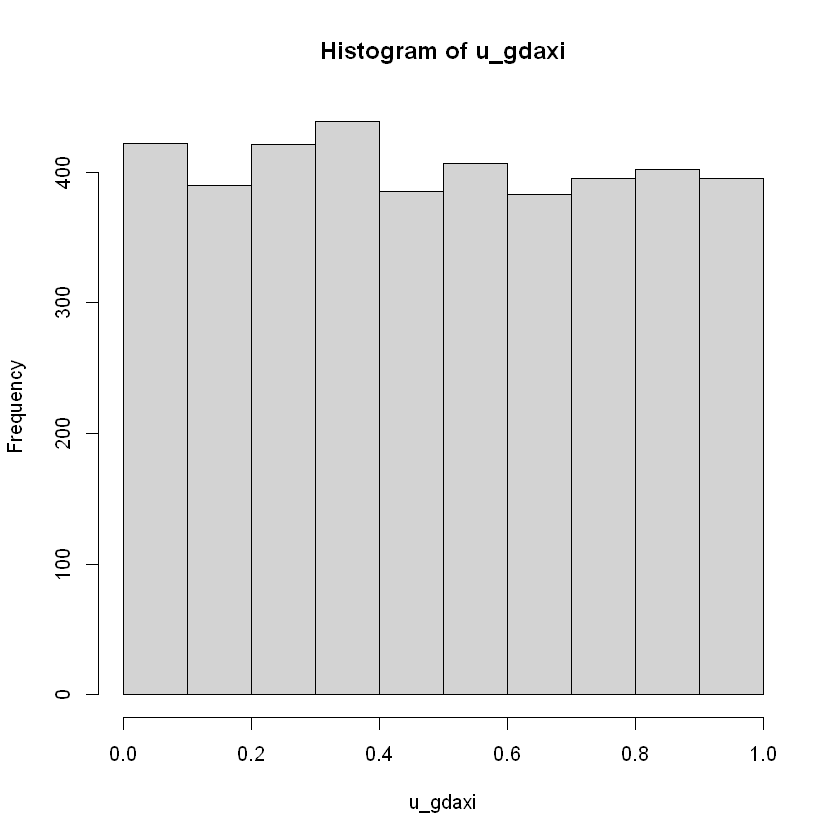

In [28]:
hist(u_gdaxi)

In [29]:
KStest2 <- LcKS(u_gdaxi, cdf = "punif")
print("Kolmogorov-Smirnov test")
print(KStest2$p.value)

ADtest2 <- ad.test(u_gdaxi, null = "punif")
print("Anderson-Darling test")
print(ADtest2$p.value)

[1] "Kolmogorov-Smirnov test"
[1] 0.2112
[1] "Anderson-Darling test"
       AD 
0.2437264 


In [31]:
Copula <- BiCopSelect(u_gdaxi, u_n225, se = TRUE)  # se = standard error
Copula

Bivariate copula: BB1 (par = 0.25, par2 = 1.08, tau = 0.17) 

##### The Copula marginals are uniform, thus to get the original modelled marginals we apply inverse cumulative distribution function/quantile function (in this case both are qsged)

In [32]:
set.seed(10)
CopulaSim <- BiCopSim(10000, family = Copula$family, Copula$par, Copula$par2) #nu = shape, xi=skew
res_gdaxi_sim <- qsged(CopulaSim[,1], nu = model_coefs_gdaxi['shape'], xi = model_coefs_gdaxi['skew']) 
res_n225_sim <- qsged(CopulaSim[,2], nu = model_coefs_n225['shape'], xi = model_coefs_n225['skew'])

##### Simulating 1-day VaR

#### Reintroducing GARCH effects

In [34]:
n225_sigmas <- best_model_n225@sigma.t
n225_res <- best_model_n225@residuals
n225_model_args <- best_model_n225@fit$par

In [35]:
n225_sigma_t <- sum (n225_model_args[c('omega', 'alpha1', 'beta1')] * c(1, tail(n225_res^2, 1), tail(n225_sigmas^2, 1)))

In [37]:
best_model_n225


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_n225, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000002305b372d38>
 [data = merged_df$log_returns_n225]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1       beta1        skew       shape  
3.4972e-04  5.2657e-06  1.1955e-01  8.5560e-01  9.1005e-01  1.4331e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     3.497e-04   1.758e-04    1.989   0.0467 *  
omega  5.266e-06   1.163e-06    4.527 5.98e-06 ***
alpha1 1.195e-01   1.389e-02    8.610  < 2e-16 ***
beta1  8.556e-01   1.636e-02   52.291  < 2e-16 ***
skew   9.101e-01   1.820e-02   49.997  < 2e-16 ***
shape  1.433e+00   4.658e-02   30.765  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 11975.28    normalized:  2.964911 

Description:
 Sun D

In [42]:
const_term <- n225_model_args['mu']
print(const_term)
n225_pred <- const_term + n225_sigma_t^(0.5)*res_n225_sim
n225_pred

          mu 
0.0003497219 


[1] -3.284426e-03  4.878380e-03 -1.163154e-02 -6.217889e-03  2.677788e-04
    [6]  3.255768e-03 -1.015009e-04 -1.298057e-03 -1.175848e-02  9.044284e-03
   [11]  5.658097e-03 -4.902941e-04  5.097542e-03 -3.140494e-03 -5.088292e-04
   [16] -1.166405e-02  1.040920e-02  6.283664e-03  1.902103e-02  2.073593e-03
   [21] -7.658576e-03 -6.300191e-04 -1.073938e-02 -7.749682e-03  5.180995e-03
   [26]  1.440763e-02 -1.228037e-03  6.958928e-04  2.159658e-04  6.598197e-04
   [31] -2.099465e-02 -1.286060e-03  9.135627e-03  4.213386e-04 -1.194095e-02
   [36] -2.528240e-03  2.353078e-03 -3.787351e-03  1.719023e-02 -8.658467e-03
   [41]  2.408298e-03  1.898089e-03 -2.500341e-02 -2.402286e-03 -1.173342e-02
   [46]  5.666792e-03  1.936230e-03  8.893244e-03  3.168723e-04 -1.682424e-02
   [51] -1.611133e-02 -1.710675e-03  1.542422e-02  4.766135e-03  5.958739e-04
   [56]  1.152885e-02 -6.382746e-04  1.453153e-02  6.593966e-03  6.045702e-03
   [61] -7.108177e-03  1.432756e-03 -8.989217e-03 -1.373981e-03  1.899671e-02
   [66] -1.321890e-02 -3.899137e-03 -5.471328e-03  1.184940e-02 -1.345904e-03
   [71] -4.502506e-03  1.061211e-02  6.562278e-03  2.966901e-03  9.109793e-03
   [76] -4.225901e-03 -1.546509e-02 -8.896008e-03 -7.555819e-03 -8.028925e-03
   [81]  2.589729e-03 -1.277528e-03 -3.062216e-03  2.321293e-02  3.813539e-03
   [86]  7.428973e-03  6.971384e-03  4.333718e-03 -1.003723e-02 -2.345474e-03
   [91] -1.136020e-02  1.304721e-04  3.883345e-03  7.316108e-03 -5.877659e-03
   [96] -2.093884e-02 -3.787145e-03  1.765640e-03 -3.701998e-03  8.467720e-03
  [101] -3.251753e-05  1.093720e-02  2.186957e-03  3.443792e-02  1.039645e-02
  [106]  5.853907e-03  6.223070e-04  2.692119e-03  3.699984e-03 -7.450121e-03
  [111]  1.860525e-03  9.832081e-03 -7.138673e-03  7.739096e-03  5.443064e-04
  [116]  3.691793e-04 -3.751510e-03 -2.538384e-03  3.947340e-03  8.345222e-03
  [121]  1.008967e-03 -1.467015e-02  5.609485e-03  9.503852e-03  7.593211e-03
  [126]  9.173913e-03 -5.380790e-03  6.319352e-03 -1.026675e-03  6.453212e-03
  [131] -7.789903e-04  5.833012e-04 -9.939496e-03 -1.355681e-03  1.044001e-02
  [136]  2.612909e-02 -4.476712e-03  2.632448e-02  7.560214e-03 -1.698010e-02
  [141]  2.467404e-02  1.173792e-02  1.443873e-02  5.082921e-03  1.211326e-02
  [146]  2.124849e-02  2.762125e-02  2.715870e-04 -8.839260e-03 -7.956536e-03
  [151] -2.741351e-02  2.387393e-03  8.087566e-03 -4.095326e-03  6.862628e-03
  [156] -1.347551e-02  2.145521e-04 -6.805836e-03 -1.181113e-02 -1.796389e-03
  [161]  4.071043e-03  3.026969e-02 -3.460173e-03 -3.510594e-03  1.736876e-02
  [166]  1.190458e-03 -4.351198e-03  2.950147e-03  6.914351e-03  1.061774e-02
  [171]  4.437924e-03 -1.182726e-02 -8.929877e-03  1.235325e-02  7.365307e-03
  [176]  2.356981e-02  4.739788e-03 -6.763982e-05  1.073225e-02  7.277902e-03
  [181] -2.777276e-03 -2.673775e-03  3.414123e-04 -2.449009e-03  1.856151e-02
  [186]  2.022407e-03 -1.371136e-02  1.254009e-03 -1.596831e-03 -1.325418e-02
  [191] -8.114300e-04  1.131027e-02 -2.552557e-03 -2.128322e-03 -1.279364e-02
  [196]  4.105674e-03  1.810464e-04  2.849275e-03  7.529113e-04  1.058487e-02
  [201]  7.623195e-03  7.463110e-03  6.920176e-04 -4.197735e-03 -7.440729e-03
  [206]  6.078530e-03  4.999923e-03 -2.660064e-02 -9.633092e-03 -3.763062e-03
  [211]  3.833504e-03  1.405612e-02  1.666146e-02  3.776977e-02  5.240896e-03
  [216] -1.894824e-02 -5.700329e-03 -1.728564e-02 -4.831417e-03  9.458618e-03
  [221]  2.811111e-02 -1.050277e-02  3.869244e-03  1.287050e-02 -6.333918e-03
  [226]  1.599024e-02 -1.750641e-02  1.091327e-03 -2.932666e-03 -1.917952e-02
  [231] -6.313793e-03 -6.282854e-03 -3.352268e-03  2.466602e-02  3.615844e-03
  [236]  1.277569e-02 -3.711752e-03 -1.819344e-03 -5.903717e-03 -2.473061e-02
  [241] -6.264798e-03 -3.637670e-03  1.580221e-02  5.027640e-03 -2.807245e-03
  [246] -5.319362e-03 -4.545599e-03 -3.246482e-04 -4.227272e-03  5.698871e-04
  [251]  2.581106e-02 -1.783400e-03 -2.010589e-03 -1.652878e-02  1.151242e-02
  [256]  1.002778e-02 -5.3

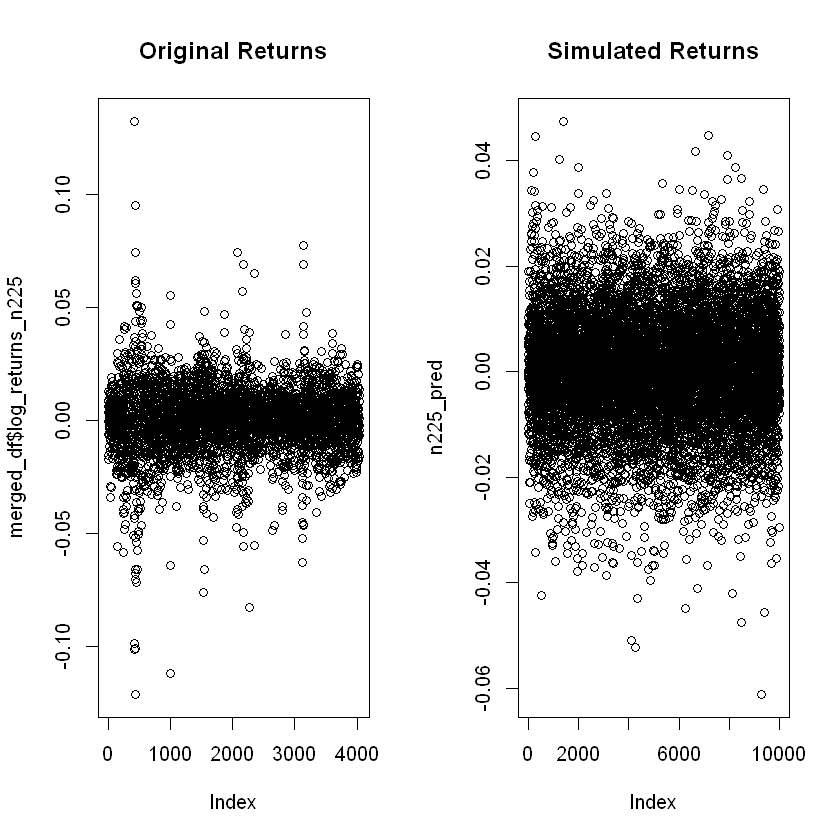

In [45]:
par(mfrow = c(1, 2))
plot(merged_df$log_returns_n225, main="Original Returns")
plot(n225_pred, main="Simulated Returns")